In [1]:
%matplotlib inline

import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from lsst.afw.table import MultiMatch, SimpleRecord, GroupView
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.pipe.base as pipeBase
from lsst.meas.astrom.loadAstrometryNetObjects import LoadAstrometryNetObjectsTask

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"
np.seterr(invalid="ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [9]:
b_branch = dafPersist.Butler("Cfht/output")
#b_branch = dafPersist.Butler("/ssd/rowen/lsstsw/build/validate_drp/cfht_saved/dm4692_2017-02-18")

b_master = dafPersist.Butler("../validate_drp_master/Cfht/output")

In [86]:
def median_dists(butler, visit1, visit2, plot=False):
    ccd_list = xrange(1,35)
    #ccd_list = [20]
    all_dists = []
    median_dists = []
    for ccdnum in ccd_list:
        exp1 = butler.get("src", visit=visit1, ccd=ccdnum, immediate=True)
        exp2 = butler.get("src", visit=visit2, ccd=ccdnum, immediate=True)

        calexp_md = butler.get("calexp_md", visit=visit1, ccd=ccdnum, immediate=True)
        calib = afwImage.Calib(calexp_md)
        calib.setThrowOnNegativeFlux(False)
        exp1_mags,_ = calib.getMagnitude(exp1['base_PsfFlux_flux'], exp1['base_PsfFlux_fluxSigma'])

        sel_magcut, = np.where(exp1_mags < 21.0)
        coord1 = SkyCoord(exp1['coord_ra'], exp1['coord_dec'], unit="rad", frame="icrs")
        coord2 = SkyCoord(exp2['coord_ra'], exp2['coord_dec'], unit="rad", frame="icrs")
        idx, chip_dists, _ = coord1.match_to_catalog_sky(coord2)
        pixel_scale = calexp_md.get('CD1_1') * 3600
        dist_sigma = pixel_scale*np.sqrt(2)*np.sqrt(exp1['slot_Centroid_xSigma']**2 +
                                                    exp1['slot_Centroid_ySigma']**2)
        
        flags = exp1["base_PixelFlags_flag_cr"] | exp1["base_PixelFlags_flag_bad"] | \
                exp1["base_PixelFlags_flag_saturated"] | exp1["base_PixelFlags_flag_edge"]
            
        
        sel, = np.where((chip_dists < 1*u.arcsec) & (exp1_mags < 21.0) & (~flags))

        #
        # Dividing by 2 to measure variance instead of separation
        #
        all_dists.append(chip_dists[sel].to(u.arcsec).value / 2)
        if plot:
            sel_plot, = np.where((chip_dists < 1*u.arcsec) & (exp1_mags < 24.0) & (~flags))
            plt.plot(exp1_mags[sel_plot], chip_dists[sel_plot].to(u.arcsec).value, '.')
            plt.ylabel("Separation (arcsec)")
            plt.xlabel("Magnitude")
            # Normalize by distance sigma
            #plt.plot(exp1_mags[sel_plot], chip_dists[sel_plot].to(u.arcsec).value/dist_sigma[sel_plot], '.')
    return ccd_list, np.array([np.median(x) for x in all_dists]), np.median(np.hstack(all_dists))


0.0121847236134


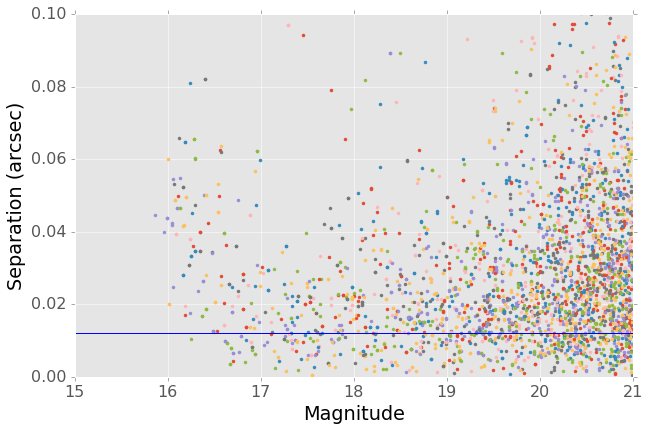

In [87]:
ccd_list, dists_branch, median_branch = median_dists(b_branch, 849375, 850587, plot=True)
plt.ylim(0,0.1)
plt.xlim(15,21)
plt.axhline(median_branch)
print median_branch

0.0122300838549


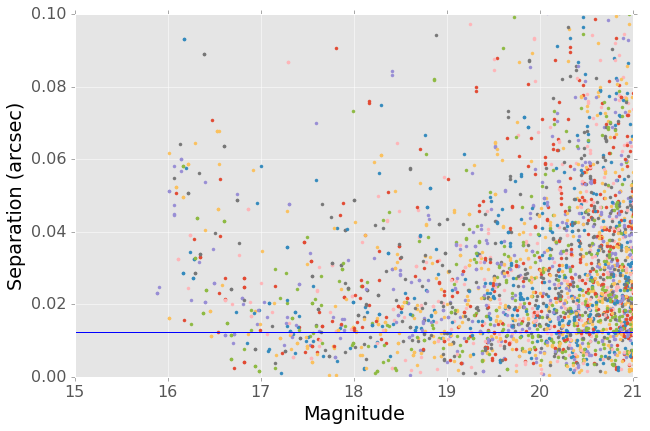

In [88]:
ccd_list, dists_master, median_master = median_dists(b_master, 849375, 850587, plot=True)
plt.ylim(0,0.1)
plt.xlim(15,21)
plt.axhline(median_master)
print median_master

The chip with all the points fainter than 24 is CCD 30.

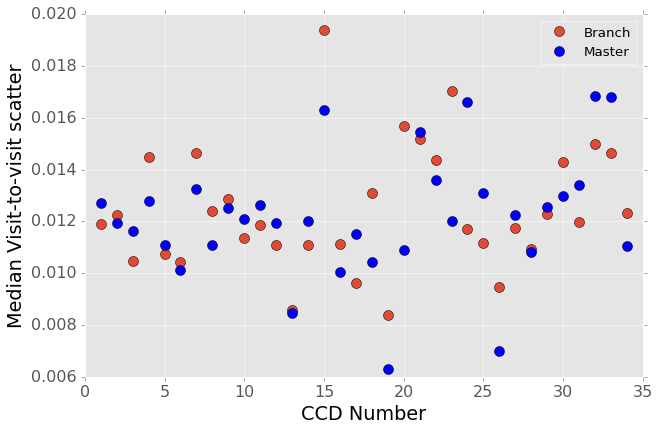

In [89]:

plt.plot(ccd_list, dists_branch, 'o', ms=10, label="Branch")
plt.plot(ccd_list, dists_master, 'bo', ms=10, label="Master")
plt.xlabel("CCD Number")
plt.ylabel("Median Visit-to-visit scatter")
plt.legend(fontsize="small", loc=0, numpoints=1)

#b.template_catalog = b_master.get("src", visit=849375, ccd=ccdnum, immediate=True)
#cmp_catalogs = [b.get("src", visit=850587, ccd=ccdnum, immediate=True),
#                b.get("src", visit=850587, ccd=ccdnum, immediate=True)]

/nfs/home/ctslater/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


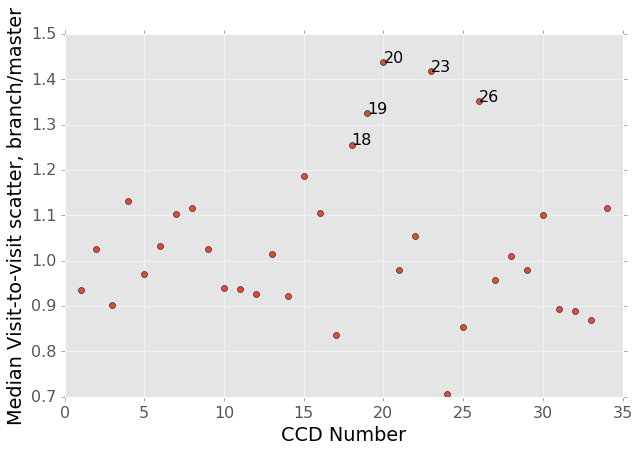

In [90]:
ratio = np.array(dists_branch)/np.array(dists_master)
plt.plot(ccd_list, ratio, 'o')
for n in np.argwhere(ratio > 1.2):
    plt.text(ccd_list[n], ratio[n], '%d' % ccd_list[n])
plt.xlabel("CCD Number")
plt.ylabel("Median Visit-to-visit scatter, branch/master")

Reported match differences
-------

This should be similar to the value reported in the log files for "found N matches scatter = 0.000 +- 0.00 arcsec"

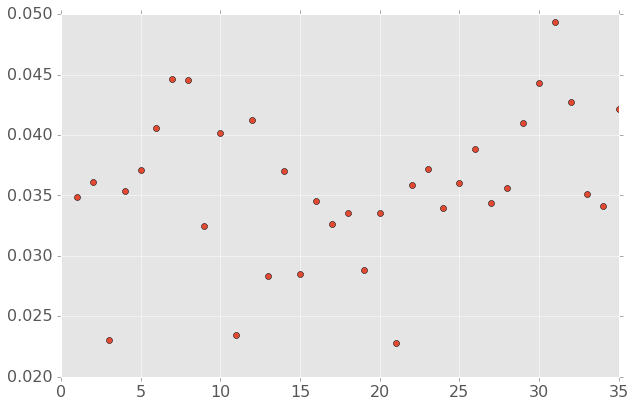

In [91]:
ccd_list = xrange(1,36)
dists = []
# 849375
for ccdnum in ccd_list:
    matches = b_branch.get("srcMatch", visit=850587, ccd=ccdnum)
    dists.append(np.median(matches['distance']))
plt.plot(ccd_list, np.array(dists)*3600*180/np.pi, 'o')

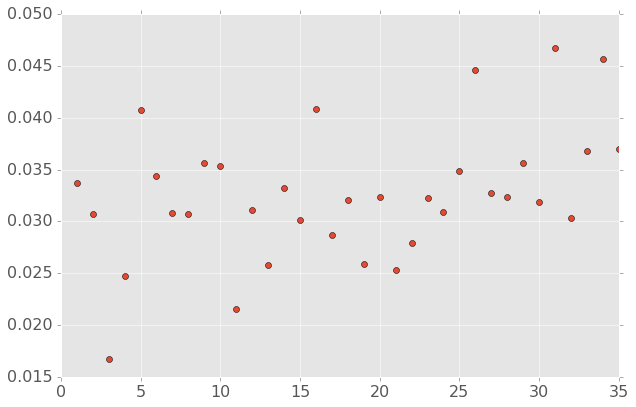

In [92]:
ccd_list = xrange(1,36)
dists = []
# 849375
for ccdnum in ccd_list:
    matches = b_branch.get("srcMatch", visit=849375, ccd=ccdnum)
    dists.append(np.median(matches['distance']))
plt.plot(ccd_list, np.array(dists)*3600*180/np.pi, 'o')

Recovering Src and Ref Catalog Matches
----------

This is loading the srcMatch (or icMatch) catalogs, reconsituting the src catalog and the reference catalog from astrometry.net, and then pulling out the matches the fitter used from these two catalogs.

In [3]:
adn_config = LoadAstrometryNetObjectsTask.ConfigClass()
refObjLoader = LoadAstrometryNetObjectsTask(adn_config)

{'defaultFilter': '', 'pixelMargin': 50, 'filterMap': {}}


In [4]:
class SrcRefDatasets:
    def __init__(self, butler, visit, ccd, match_dtype="srcMatch"):
        self.butler = butler
        self.src = butler.get("src", visit=visit, ccd=ccd, immediate=True)
        self.exposure = butler.get('calexp',  visit=visit, ccd=ccd, immediate=True)
        self.calexp_md = butler.get('calexp_md',  visit=visit, ccd=ccd, immediate=True)
        self.matches = butler.get(match_dtype, visit=visit, ccd=ccd, immediate=True)
        
        self.calib = afwImage.Calib(self.calexp_md)
        loadRes = refObjLoader.loadPixelBox(
            bbox = self.exposure.getBBox(),
            wcs = self.exposure.getWcs(),
            filterName = 'r',
            calib = self.calib)
        self.refCat = loadRes.refCat
        self.reference_ids = np.array([source.getId() for source in self.refCat])
        

In [7]:
ccdnum = 20
visit = 849375
src_ref_branch = SrcRefDatasets(b_branch, visit, ccdnum)
src_ref_master = SrcRefDatasets(b_master, visit, ccdnum, match_dtype="icMatch")

Ref cat length, branch:  51
Ref cat length, master:  41


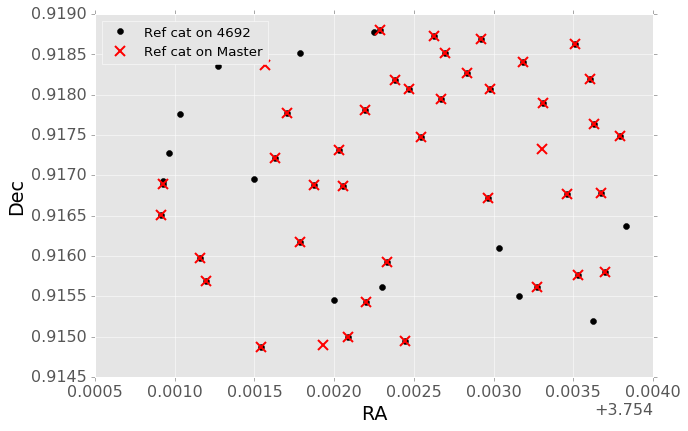

In [26]:
kwargs = {"label": "Ref cat on 4692"}
for s_ref_id, s_src_id in zip(src_ref_branch.matches['first'], src_ref_branch.matches['second']):
    sel_ref, = np.where(src_ref_branch.reference_ids == s_ref_id)
    plt.plot(src_ref_branch.refCat[sel_ref[0]]['coord_ra'],
             src_ref_branch.refCat[sel_ref[0]]['coord_dec'], 'ko', **kwargs)
    kwargs = {}
print "Ref cat length, branch: ", len(src_ref_branch.matches['first'])

kwargs = {"label": "Ref cat on Master"}
for s_ref_id, s_src_id in zip(src_ref_master.matches['first'], src_ref_master.matches['second']):
    sel_ref, = np.where(src_ref_master.reference_ids == s_ref_id)
    plt.plot(src_ref_master.refCat[sel_ref[0]]['coord_ra'],
             src_ref_master.refCat[sel_ref[0]]['coord_dec'], 'rx', ms=10, mew=2, **kwargs)
    kwargs = {}
print "Ref cat length, master: ", len(src_ref_master.matches['first'])
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend(loc=0, numpoints=1, fontsize="small")